# **Olympic Medal Prediction**

## Importing Libraries


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

import tensorflow as tf
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

## Reading Dataset

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%cd /content/gdrive/MyDrive/BDA

/content/gdrive/MyDrive/BDA


In [4]:
data = pd.read_csv('athlete_events.csv')

In [5]:
data

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271111,135569,Andrzej ya,M,29.0,179.0,89.0,Poland-1,POL,1976 Winter,1976,Winter,Innsbruck,Luge,Luge Mixed (Men)'s Doubles,NaN
271112,135570,Piotr ya,M,27.0,176.0,59.0,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Individual",NaN
271113,135570,Piotr ya,M,27.0,176.0,59.0,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Team",NaN
271114,135571,Tomasz Ireneusz ya,M,30.0,185.0,96.0,Poland,POL,1998 Winter,1998,Winter,Nagano,Bobsleigh,Bobsleigh Men's Four,NaN


## Data Inspecting and Cleaning

In [6]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271116 entries, 0 to 271115
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      271116 non-null  int64  
 1   Name    271116 non-null  object 
 2   Sex     271116 non-null  object 
 3   Age     261642 non-null  float64
 4   Height  210945 non-null  float64
 5   Weight  208241 non-null  float64
 6   Team    271116 non-null  object 
 7   NOC     271116 non-null  object 
 8   Games   271116 non-null  object 
 9   Year    271116 non-null  int64  
 10  Season  271116 non-null  object 
 11  City    271116 non-null  object 
 12  Sport   271116 non-null  object 
 13  Event   271116 non-null  object 
 14  Medal   39783 non-null   object 
dtypes: float64(3), int64(2), object(10)
memory usage: 31.0+ MB


In [7]:
data.shape

(271116, 15)

In [8]:
data['Medal'].value_counts()

Gold      13372
Bronze    13295
Silver    13116
Name: Medal, dtype: int64

In [9]:
data['Team'].value_counts()

United States       17847
France              11988
Great Britain       11404
Italy               10260
Germany              9326
                    ...  
Gyp-6                   1
Ducky-16                1
Hb-20                   1
Demi-Mondaine-15        1
Mainz                   1
Name: Team, Length: 1184, dtype: int64

In [10]:
# To fill missing values in Medal column
data['Medal'] = data['Medal'].apply(lambda x: 1 if str(x) != 'nan' else 0)


In [11]:
data

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,0
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,0
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,0
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,1
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271111,135569,Andrzej ya,M,29.0,179.0,89.0,Poland-1,POL,1976 Winter,1976,Winter,Innsbruck,Luge,Luge Mixed (Men)'s Doubles,0
271112,135570,Piotr ya,M,27.0,176.0,59.0,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Individual",0
271113,135570,Piotr ya,M,27.0,176.0,59.0,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Team",0
271114,135571,Tomasz Ireneusz ya,M,30.0,185.0,96.0,Poland,POL,1998 Winter,1998,Winter,Nagano,Bobsleigh,Bobsleigh Men's Four,0


In [12]:
# Drop Unnecessary columns
data = data.drop(['ID', 'Name', 'Games'], axis=1)


In [13]:
# Checking null values in the data 
data.isna().mean()


Sex       0.000000
Age       0.034944
Height    0.221938
Weight    0.231912
Team      0.000000
NOC       0.000000
Year      0.000000
Season    0.000000
City      0.000000
Sport     0.000000
Event     0.000000
Medal     0.000000
dtype: float64

In [14]:
data.groupby(['Medal', 'Sex']).mean().astype(np.int)

Age  Height  Weight  Year
Medal Sex                           
0     F     23     167      59  1992
      M     26     178      75  1974
1     F     24     170      63  1992
      M     26     181      79  1966

In [15]:
# Fill null values with mean values for these columns
for column in ['Age', 'Height', 'Weight']:
    data[column] = data.groupby(['Medal', 'Sex'])[column].apply(lambda x: x.fillna(x.mean()).astype(np.int))

In [16]:
print("Total missing values:", data.isna().sum().sum())


Total missing values: 0


In [17]:
data

,Sex,Age,Height,Weight,Team,NOC,Year,Season,City,Sport,Event,Medal
0,M,24,180,80,China,CHN,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,0
1,M,23,170,60,China,CHN,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,0
2,M,24,178,75,Denmark,DEN,1920,Summer,Antwerpen,Football,Football Men's Football,0
3,M,34,181,79,Denmark/Sweden,DEN,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,1
4,F,21,185,82,Netherlands,NED,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,0
...,...,...,...,...,...,...,...,...,...,...,...,...
271111,M,29,179,89,Poland-1,POL,1976,Winter,Innsbruck,Luge,Luge Mixed (Men)'s Doubles,0
271112,M,27,176,59,Poland,POL,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Individual",0
271113,M,27,176,59,Poland,POL,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Team",0
271114,M,30,185,96,Poland,POL,1998,Winter,Nagano,Bobsleigh,Bobsleigh Men's Four,0


In [18]:
# Checking no of unique values in the column
{column: len(data[column].unique()) for column in data.select_dtypes('object').columns}

{'City': 42,
 'Event': 765,
 'NOC': 230,
 'Season': 2,
 'Sex': 2,
 'Sport': 66,
 'Team': 1184}

In [19]:
def binary_encode(df, columns, positive_values):
    df = df.copy()
    for column, positive_value in zip(columns, positive_values):
        df[column] = df[column].apply(lambda x: 1 if x == positive_value else 0)
    return df

def onehot_encode(df, columns, prefixes):
    df = df.copy()
    for column, prefix in zip(columns, prefixes):
        dummies = pd.get_dummies(df[column], prefix=prefix)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)
    return df

In [20]:
data = binary_encode(
    data,
    columns=['Sex', 'Season'],
    positive_values=['M', 'Summer']
)

data = onehot_encode(
    data,
    columns=['Team', 'NOC', 'City', 'Sport', 'Event'],
    prefixes=['T', 'N', 'C', 'S', 'E']
)

In [21]:
data

,Sex,Age,Height,Weight,Year,Season,Medal,T_30. Februar,T_A North American Team,T_Acipactli,T_Acturus,T_Afghanistan,T_Akatonbo,T_Alain IV,T_Albania,T_Alcaid,T_Alcyon-6,T_Alcyon-7,T_Aldebaran,T_Aldebaran II,T_Aletta,T_Algeria,T_Ali-Baba II,T_Ali-Baba IV,T_Ali-Baba IX,T_Ali-Baba VI,T_Allegro,T_Almaz,T_Aloha II,T_Amateur Athletic Association,T_American Samoa,T_Amolgavar,T_Amstel Amsterdam,T_Amulet-3,T_Amulet-7,T_Ancora,T_Andorinha,T_Andorra,T_Andromeda,T_Angelita,...,E_Weightlifting Men's Super-Heavyweight,"E_Weightlifting Men's Unlimited, One Hand","E_Weightlifting Men's Unlimited, Two Hands",E_Weightlifting Women's Featherweight,E_Weightlifting Women's Flyweight,E_Weightlifting Women's Heavyweight,E_Weightlifting Women's Light-Heavyweight,E_Weightlifting Women's Lightweight,E_Weightlifting Women's Middleweight,E_Weightlifting Women's Super-Heavyweight,"E_Wrestling Men's All-Around, Greco-Roman","E_Wrestling Men's Bantamweight, Freestyle","E_Wrestling Men's Bantamweight, Greco-Roman","E_Wrestling Men's Featherweight, Freestyle","E_Wrestling Men's Featherweight, Greco-Roman","E_Wrestling Men's Flyweight, Freestyle","E_Wrestling Men's Flyweight, Greco-Roman","E_Wrestling Men's Heavyweight, Freestyle","E_Wrestling Men's Heavyweight, Greco-Roman","E_Wrestling Men's Light-Flyweight, Freestyle","E_Wrestling Men's Light-Flyweight, Greco-Roman","E_Wrestling Men's Light-Heavyweight, Freestyle","E_Wrestling Men's Light-Heavyweight, Greco-Roman","E_Wrestling Men's Lightweight, Freestyle","E_Wrestling Men's Lightweight, Greco-Roman","E_Wrestling Men's Middleweight A, Greco-Roman","E_Wrestling Men's Middleweight B, Greco-Roman","E_Wrestling Men's Middleweight, Freestyle","E_Wrestling Men's Middleweight, Greco-Roman","E_Wrestling Men's Super-Heavyweight, Freestyle","E_Wrestling Men's Super-Heavyweight, Greco-Roman","E_Wrestling Men's Unlimited Class, Greco-Roman","E_Wrestling Men's Welterweight, Freestyle","E_Wrestling Men's Welterweight, Greco-Roman","E_Wrestling Women's Featherweight, Freestyle","E_Wrestling Women's Flyweight, Freestyle","E_Wrestling Women's Heavyweight, Freestyle","E_Wrestling Women's Light-Heavyweight, Freestyle","E_Wrestling Women's Lightweight, Freestyle","E_Wrestling Women's Middleweight, Freestyle"
0,1,24,180,80,1992,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,23,170,60,2012,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,24,178,75,1920,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,34,181,79,1900,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,21,185,82,1988,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271111,1,29,179,89,1976,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
271112,1,27,176,59,2014,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
271113,1,27,176,59,2014,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
271114,1,30,185,96,1998,0,0

In [22]:
data.iloc[:, [1000,1400,1500,1800]]

,T_Stade Franais AC-2,N_UAE,S_Motorboating,E_Cycling Men's Individual Time Trial
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
271111,0,0,0,0
271112,0,0,0,0
271113,0,0,0,0
271114,0,0,0,0


In [23]:
# Spilt data in target column and features columns
y = data['Medal']
X = data.drop('Medal', axis=1)

## Feature Selection

In [24]:
#Apply SelectKBest and extract top 10 features
best=SelectKBest(score_func=chi2, k=10)

In [25]:
fit=best.fit(X,y)


In [26]:
data_scores=pd.DataFrame(fit.scores_)
data_columns=pd.DataFrame(X.columns)

In [27]:
#Join the two dataframes
scores=pd.concat([data_columns,data_scores],axis=1)
scores.columns=['Feature','Score']
print(scores.nlargest(11,'Score'))


                  Feature        Score
3                  Weight  6918.210040
1404                N_URS  3912.466445
982        T_Soviet Union  3875.363234
1406                N_USA  3490.799425
1101      T_United States  3025.609256
2                  Height  1475.570949
1505             S_Rowing  1457.130819
1266                N_GDR  1149.074852
307        T_East Germany  1012.719371
1506              S_Rugby   942.009049
1988  E_Rugby Men's Rugby   942.009049


In [28]:
#Select 10 features
features=scores["Feature"].tolist()[:10]
features

['Sex',
 'Age',
 'Height',
 'Weight',
 'Year',
 'Season',
 'T_30. Februar',
 'T_A North American Team',
 'T_Acipactli',
 'T_Acturus']

## Make new dataset with cleaned data

In [29]:
data=data[['Age','Sex','Height','Weight','Year','Season','T_30. Februar','T_A North American Team','T_Acipactli','T_Acturus','Medal']]
data.head()

,Age,Sex,Height,Weight,Year,Season,T_30. Februar,T_A North American Team,T_Acipactli,T_Acturus,Medal
0,24,1,180,80,1992,1,0,0,0,0,0
1,23,1,170,60,2012,1,0,0,0,0,0
2,24,1,178,75,1920,1,0,0,0,0,0
3,34,1,181,79,1900,1,0,0,0,0,1
4,21,0,185,82,1988,0,0,0,0,0,0


In [30]:
y = data['Medal']
X = data.drop(['Medal'], axis=1)

#Split data into training and testing data
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.4, random_state=1)


## Feature Scaling

In [31]:
# Scaling data 
scaler = MinMaxScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

## Predictive Modeling

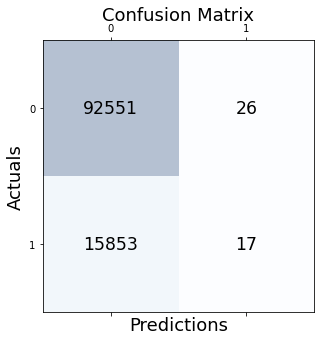



Accuracy of Logistic Regression: 85.35782455946223 

              precision    recall  f1-score   support

           0       0.85      1.00      0.92     92577
           1       0.40      0.00      0.00     15870

    accuracy                           0.85    108447
   macro avg       0.62      0.50      0.46    108447
weighted avg       0.79      0.85      0.79    108447



In [32]:
m1 = 'LogisticRegression'
lr = LogisticRegression(random_state=1, max_iter=1000)
lr.fit(train_x, train_y)
lr_predict = lr.predict(test_x)
lr_conf_matrix = confusion_matrix(test_y, lr_predict)
lr_acc_score = accuracy_score(test_y, lr_predict)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(lr_conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(lr_conf_matrix.shape[0]):
    for j in range(lr_conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=lr_conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

print("\n")
print("Accuracy of Logistic Regression:",lr_acc_score*100,'\n')
print(classification_report(test_y,lr_predict))

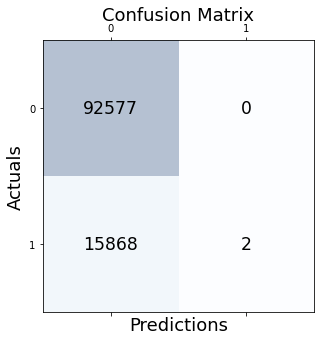



Accuracy of Logistic Regression: 85.36796776305476 

              precision    recall  f1-score   support

           0       0.85      1.00      0.92     92577
           1       1.00      0.00      0.00     15870

    accuracy                           0.85    108447
   macro avg       0.93      0.50      0.46    108447
weighted avg       0.88      0.85      0.79    108447



In [33]:
m2 = 'MultinomialNB'
nv = MultinomialNB()
nv.fit(train_x, train_y)
nv_predict = nv.predict(test_x)
nv_conf_matrix = confusion_matrix(test_y, nv_predict)
nv_acc_score = accuracy_score(test_y, nv_predict)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(nv_conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(nv_conf_matrix.shape[0]):
    for j in range(nv_conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=nv_conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

print("\n")
print("Accuracy of Logistic Regression:",nv_acc_score*100,'\n')
print(classification_report(test_y,nv_predict))

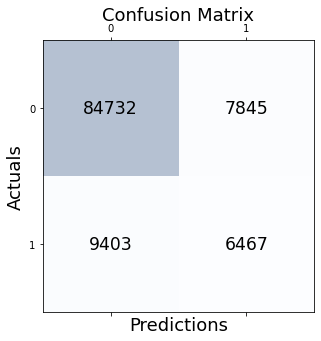



Accuracy of DecisionTreeClassifier: 84.09545676689996 

              precision    recall  f1-score   support

           0       0.90      0.92      0.91     92577
           1       0.45      0.41      0.43     15870

    accuracy                           0.84    108447
   macro avg       0.68      0.66      0.67    108447
weighted avg       0.83      0.84      0.84    108447



In [34]:
m3 = 'DecisionTreeClassifier'
dt = DecisionTreeClassifier(criterion = 'entropy',random_state=0,max_depth = 30)
dt.fit(train_x,train_y)
dt_predicted = dt.predict(test_x)
dt_conf_matrix = confusion_matrix(test_y, dt_predicted)
dt_acc_score = accuracy_score(test_y, dt_predicted)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(dt_conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(dt_conf_matrix.shape[0]):
    for j in range(dt_conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=dt_conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

print("\n")
print("Accuracy of DecisionTreeClassifier:",dt_acc_score*100,'\n')
print(classification_report(test_y,dt_predicted))

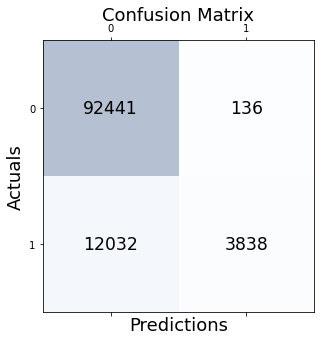



Accuracy of Random Forest: 88.77977260781765 

              precision    recall  f1-score   support

           0       0.88      1.00      0.94     92577
           1       0.97      0.24      0.39     15870

    accuracy                           0.89    108447
   macro avg       0.93      0.62      0.66    108447
weighted avg       0.90      0.89      0.86    108447



In [35]:
m4 = 'Random Forest Classfier'
rf = RandomForestClassifier(n_estimators=200, random_state=0,max_depth=12)
rf.fit(train_x,train_y)
rf_predicted = rf.predict(test_x)
rf_conf_matrix = confusion_matrix(test_y, rf_predicted)
rf_acc_score = accuracy_score(test_y, rf_predicted)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(rf_conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(rf_conf_matrix.shape[0]):
    for j in range(rf_conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=rf_conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

print("\n")
print("Accuracy of Random Forest:",rf_acc_score*100,'\n')
print(classification_report(test_y,rf_predicted))

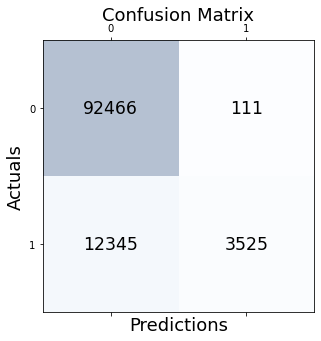



Accuracy of Gradient Boosting Classifier: 88.51420509557664 

              precision    recall  f1-score   support

           0       0.88      1.00      0.94     92577
           1       0.97      0.22      0.36     15870

    accuracy                           0.89    108447
   macro avg       0.93      0.61      0.65    108447
weighted avg       0.89      0.89      0.85    108447



In [36]:
m5 = 'Gradient Boosting Classifier'
gvc =  GradientBoostingClassifier()
gvc.fit(train_x,train_y)
gvc_predicted = gvc.predict(test_x)
gvc_conf_matrix = confusion_matrix(test_y, gvc_predicted)
gvc_acc_score = accuracy_score(test_y, gvc_predicted)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(gvc_conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(gvc_conf_matrix.shape[0]):
    for j in range(gvc_conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=gvc_conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

print("\n")
print("Accuracy of Gradient Boosting Classifier:",gvc_acc_score*100,'\n')
print(classification_report(test_y,gvc_predicted))

In [37]:
m6 = 'Neural Network'
inputs = tf.keras.Input(shape=(X.shape[1]))
x = tf.keras.layers.Dense(64, activation='relu')(inputs)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)


model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)


history = model.fit(
    train_x,
    train_y,
    validation_split=0.2,
    batch_size=32,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
4067/4067 [==============================] - 10s 2ms/step - loss: 0.4091 - accuracy: 0.8523 - auc: 0.6066 - val_loss: 0.3948 - val_accuracy: 0.8550 - val_auc: 0.6443
Epoch 2/100
4067/4067 [==============================] - 8s 2ms/step - loss: 0.3956 - accuracy: 0.8532 - auc: 0.6521 - val_loss: 0.3817 - val_accuracy: 0.8535 - val_auc: 0.7010
Epoch 3/100
4067/4067 [==============================] - 8s 2ms/step - loss: 0.3742 - accuracy: 0.8647 - auc: 0.7014 - val_loss: 0.3590 - val_accuracy: 0.8722 - val_auc: 0.7301
Epoch 4/100
4067/4067 [==============================] - 8s 2ms/step - loss: 0.3604 - accuracy: 0.8717 - auc: 0.7295 - val_loss: 0.3518 - val_accuracy: 0.8754 - val_auc: 0.7383
Epoch 5/100
4067/4067 [==============================] - 8s 2ms/step - loss: 0.3548 - accuracy: 0.8737 - auc: 0.7368 - val_loss: 0.3499 - val_accuracy: 0.8769 - val_auc: 0.7391
Epoch 6/100
4067/4067 [==============================] - 8s 2ms/step - loss: 0.3517 - accuracy: 0.8752 - auc: 0.74

In [38]:
model.evaluate(test_x, test_y)

3389/3389 [==============================] - 4s 1ms/step - loss: 0.3347 - accuracy: 0.8818 - auc: 0.7585


[0.33470961451530457, 0.8818408846855164, 0.7584984302520752]

In [39]:
y_true = np.array(test_y)
y_pred = np.squeeze(np.array(model.predict(test_x) >= 0.5, dtype=np.int))

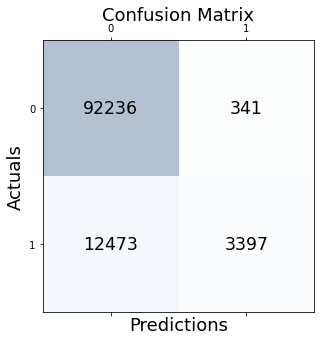



Accuracy of Neural Network: 88.1840899241104 

              precision    recall  f1-score   support

           0       0.88      1.00      0.94     92577
           1       0.91      0.21      0.35     15870

    accuracy                           0.88    108447
   macro avg       0.89      0.61      0.64    108447
weighted avg       0.88      0.88      0.85    108447



In [40]:
nn_conf_matrix = confusion_matrix(y_true, y_pred)
nn_acc_score = accuracy_score(y_true, y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(nn_conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(nn_conf_matrix.shape[0]):
    for j in range(nn_conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=nn_conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

print("\n")
print("Accuracy of Neural Network:",nn_acc_score*100,'\n')
print(classification_report(y_true, y_pred))

## Model Evaluation

In [41]:
model_ev = pd.DataFrame({'Model': ['Logistic Regression','MultinomialNB','Decision Tree','Random Forest',
                                  'Gradient Boosting','Neural Network'], 
                         'Accuracy': [lr_acc_score*100, nv_acc_score*100, dt_acc_score*100, rf_acc_score*100,gvc_acc_score*100,
                                      nn_acc_score*100]})
model_ev

,Model,Accuracy
0,Logistic Regression,85.357825
1,MultinomialNB,85.367968
2,Decision Tree,84.095457
3,Random Forest,88.779773
4,Gradient Boosting,88.514205
5,Neural Network,88.184090


## Final Random Forest Classifier Model


In [44]:
model = RandomForestClassifier(n_estimators=200, random_state=0,max_depth=12)
model.fit(train_x,train_y)
predicted = model.predict(test_x)
accuracy = accuracy_score(test_y, rf_predicted)
print("Accuracy of Random Forest:",accuracy*100,'\n')

Accuracy of Random Forest: 88.77977260781765 



## Conclusion
Random Forest Classifier Model performs best among all models